In [3]:
import os
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [4]:
%matplotlib inline

In [5]:
DATA = "../data/books/compare-compression-frames/"

In [6]:
def captureAndSave(b_uncompressed=False):
    ''' return: img1, img2 as np.ndarry; write img1 and img2 to file '''
    
    cam = cv2.VideoCapture(0)
    
    _savefn = DATA + "vidout.avi"
    _outshape = (640,480)
    _outfps = 30
    _fourcc = cv2.VideoWriter_fourcc("X","2","6","4")
    
    if b_uncompressed:
        _outfps = 0
        _fourcc = 0
    
    out = cv2.VideoWriter(_savefn,_fourcc,_outfps,_outshape)
    
    #dummy read
    ret,frame = cam.read()
    
    ret,frame = cam.read()
    img1 = frame.copy()
    out.write(frame)
    
    ret,frame = cam.read()
    img2 = frame.copy()
    out.write(frame)
    
    out.release()
    cam.release()
    
    return img1, img2
    

In [7]:
def loadFramesFromVid():
    ''' load the compressed video and extract'''
    
    cam = cv2.VideoCapture(DATA + "vidout.avi")
    
    ret,frame = cam.read()

    img1 = frame.copy()
    
    ret, frame = cam.read()
    img2 = frame.copy()
    
    cam.release()
    
    return img1, img2

In [37]:
def diffSummary(img_a, img_b, b_gray=True, b_pixels=False):
    ''' returns number of different pixels img_a vs img_b
                in grayscale if b_gray=True
    '''
    if b_gray:
        _a = cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)
        _b = cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY)    
        frame_diff = cv2.absdiff(_a, _b)
        if b_pixels:
            return sum(map(lambda arr: len(filter(lambda elem: elem > 0, arr)), frame_diff))
        return sum(sum(frame_diff))
    else:
        frame_diff = cv2.absdiff(img_a, img_b)
        return sum(sum(sum(frame_diff)))

In [38]:
print diffSummary( cv2.imread(DATA+"output.jpg")
                  ,cv2.imread(DATA+"output.png")
                  ,b_gray=True
                 )
print diffSummary( cv2.imread(DATA+"output.jpg")
                  ,cv2.imread(DATA+"output.png")
                  ,b_gray=True
                  ,b_pixels=True
                 )
print diffSummary( cv2.imread(DATA+"output.jpg")
                  ,cv2.imread(DATA+"output.png")
                  ,b_gray=False
                 )
print diffSummary( cv2.imread(DATA+"output.png")
                  ,cv2.imread(DATA+"output.png")
                  ,b_gray=False
                 )

178
168
563
0


In [10]:
def saveAsPngAndJpg(img):
    cv2.imwrite(DATA + "save.png", img)
    cv2.imwrite(DATA + "save.jpg", img)
    
def loadSavedImgs():
    img_png = cv2.imread(DATA + "save.png")
    img_jpg = cv2.imread(DATA + "save.jpg")
    return img_png, img_jpg

###### Test for compression conditions / display sizes

In [35]:
origImg1, origImg2 = captureAndSave()

assert type(origImg1).__name__ == 'ndarray'
assert type(origImg2).__name__ == 'ndarray'

assert origImg1.shape == (480,640,3)
assert origImg2.shape == (480,640,3)

assert diffSummary(origImg1, origImg2) > 0

vidCompImg1, vidCompImg2 = loadFramesFromVid()

saveAsPngAndJpg(origImg1)
pngCompImg1, jpgCompImg1 = loadSavedImgs()

#Png is lossless, but jpg distorts
assert diffSummary(origImg1, pngCompImg1)   == 0
assert diffSummary(origImg1, jpgCompImg1)    > 0
assert diffSummary(pngCompImg1, jpgCompImg1) > 0

#h264 is different, different then jpg too
assert diffSummary(origImg1, vidCompImg1) > 0
assert diffSummary(origImg2, vidCompImg2) > 0

assert diffSummary(pngCompImg1, vidCompImg1) > 0
assert diffSummary(jpgCompImg1, vidCompImg1) > 0

# look at size on disk
print 'jpg file size:   %i' % os.path.getsize(DATA + "save.jpg")
print 'png file size:   %i' % os.path.getsize(DATA + "save.png")
print 'avi size (2x):   %i' % os.path.getsize(DATA + "vidout.avi")

#look at size in memory
print ''
print 'image shape:      %s' % str(origImg1.shape)
print 'product of dims:  %i '% reduce( lambda x,y: x*y ,origImg1.shape)
print 'memory size:      %i' % sys.getsizeof(origImg1)

#Look at ratios
print ''

pct_comp = float(os.path.getsize(DATA + "save.png")) / float(sys.getsizeof(origImg1))
print 'loseless compression pct: %.2f' % pct_comp

pct_comp = float(os.path.getsize(DATA + "save.jpg")) / float(sys.getsizeof(origImg1))
print 'jpg compression pct:      %.2f' % pct_comp

#Look at diffs
print ''
x = origImg1.shape[0] * origImg1.shape[1]
def div(x,y):
    return float(x) / float(y)
print 'b/w two adjacent frames: %.2f' % div(diffSummary(origImg1, origImg2), x)
print 'b/w png/jpg:             %.2f' % div(diffSummary(pngCompImg1, jpgCompImg1), x)
print 'b/w png/h264:            %.2f' % div(diffSummary(pngCompImg1, vidCompImg1), x)
print 'b/w jpg/h264:            %.2f' % div(diffSummary(jpgCompImg1, vidCompImg1), x)

print 'discrete pixel png/jpg:  %.2f' % div(diffSummary(pngCompImg1, jpgCompImg1, b_pixels=True), x)


jpg file size:   68404
png file size:   352906
avi size (2x):   31848

image shape:      (480, 640, 3)
product of dims:  921600 
memory size:      921664

loseless compression pct: 0.38
jpg compression pct:      0.07

b/w two adjacent frames: 0.26
b/w png/jpg:             0.30
b/w png/h264:            0.27
b/w jpg/h264:            0.27
discrete pixel png/jpg:  0.45


###### test for uncompressed videowriter

In [14]:
img1, img2 = captureAndSave(b_uncompressed = True)
vidImg1, vidImg2 = loadFramesFromVid()

#show this works for losseless
print 'diff b/w two adjacent frames:              %i' % diffSummary(img1, img2)
print 'diff b/w orig and video saved/loaded img1: %i' % diffSummary(img1, vidImg1)
print 'diff b/w orig and video saved/loaded img1: %i' % diffSummary(img2, vidImg2)

diff b/w two adjacent frames:              86164
diff b/w orig and video saved/loaded img1: 0
diff b/w orig and video saved/loaded img1: 0


###### Visualize the diff in compression

b/w two adjacent frames


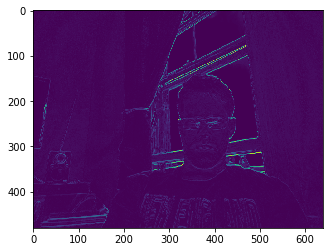

b/w png/jpg


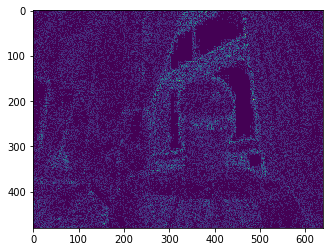

b/w png/h264


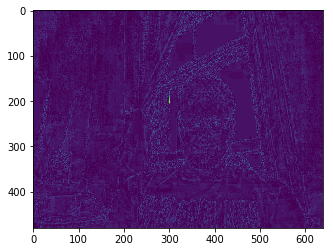

b/w jpg/h264


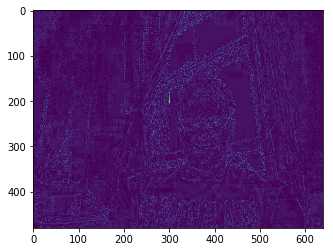

b/w orig/lossless


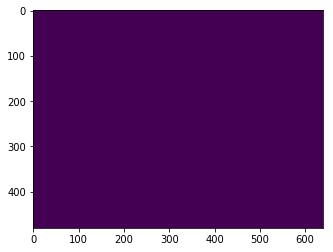

In [36]:
def diffViz(img_a, img_b, b_gray=True):
    ''' returns number of different pixels img_a vs img_b
                in grayscale if b_gray=True
    '''
    if b_gray:
        _a = cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)
        _b = cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY)    
        frame_diff = cv2.absdiff(_a, _b)
        
    else:
        frame_diff = cv2.absdiff(img_a, img_b)
    
    plt.imshow(frame_diff)
    plt.show()
    
print 'b/w two adjacent frames'
diffViz(origImg1, origImg2)

print 'b/w png/jpg'
diffViz(pngCompImg1, jpgCompImg1)

print 'b/w png/h264' 
diffViz(pngCompImg1, vidCompImg1)

print 'b/w jpg/h264'
diffViz(jpgCompImg1, vidCompImg1)

print 'b/w orig/lossless'
diffViz(pngCompImg1, origImg1)

###### A simple example with a 50x50 image: how does disk storage differ

In [16]:
DATA = "../data/books/compare-compression-frames/"
fn = DATA + "rect11.jpg"
img = cv2.imread(fn)

print 'image shape:      %s' % str(img.shape)
print 'product of dims:  %i '% reduce( lambda x,y: x*y ,img.shape)
print 'memory size:      %i' % sys.getsizeof(img)
print 'file size:        %i' % os.path.getsize(fn)


image shape:      (50, 50, 3)
product of dims:  7500 
memory size:      7564
file size:        1955


In [17]:
cv2.imwrite(DATA + "output.png", img)
cv2.imwrite(DATA + "output.jpg", img)

print 'jpg file size:   %i' % os.path.getsize(DATA + "output.jpg")
print 'png file size:   %i' % os.path.getsize(DATA + "output.png")

jpg file size:   1943
png file size:   5023
